# This notebook compare the SNPs between H3Africa and 1KG

1. SNP AF looks similar in H3Africa and 1KG after remove some alleles either not present in 1KG, or multi-alleles in 1KG, or \<INS>/\<DEL> in 1kg

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

## Load files

In [3]:
af_1kg_dir ="../../additional_files/AFR_AF_from_1kg/" 
af_1kg_df = pd.DataFrame()
for chrom in range(1,22):
    curr_file = f"{af_1kg_dir}chr{chrom}_allele_frequencies.txt"
    curr_df = pd.read_csv(curr_file,sep="\t",header=None,names=["CHROM","POS","REF","ALT","AF"])
    af_1kg_df = pd.concat([curr_df, af_1kg_df],ignore_index=True)

In [4]:
print(f"1KG have {len(af_1kg_df):,} SNPs.")

1KG have 80,168,198 SNPs.


In [5]:
# H3Africa are all bi-alleles SNPs
h3afr_dir ="../../results/converted_vcf/"
h3afr_df = pd.DataFrame()
for chrom in range(1,22):
    curr_file = f"{h3afr_dir}chr{chrom}_allele_frequencies.txt"
    curr_df = pd.read_csv(curr_file,sep="\t",header=None,names=["CHROM","POS","REF","ALT","AF"])
    h3afr_df = pd.concat([curr_df, h3afr_df],ignore_index=True)
print(f"H3Africa have {len(h3afr_df):,} SNPs.")

H3Africa have 1,708,611 SNPs.


In [ ]:
## add extra filter of F_MISSING
h3afr_dir ="../../results/converted_vcf/"
missing_df = pd.DataFrame()
for chrom in range(1,22):
    curr_file = f"{h3afr_dir}chr{chrom}_F_MISSING.vmiss"
    curr_df = pd.read_csv(curr_file,sep="\t", usecols=["#CHROM","POS","F_MISS"])
    missing_df = pd.concat([curr_df, missing_df],ignore_index=True)
missing_df.rename(columns={"#CHROM":"CHROM"},inplace=True)

## Filter H3Africa SNPs

In [6]:
h3afr_df_merged = h3afr_df.merge(af_1kg_df,on=["CHROM","POS"],suffixes=["_h3_AFR","_1kg_AFR"], how="left")

In [7]:
snp_notIn_1kg = h3afr_df_merged.AF_1kg_AFR.isnull()
snp_notBiIn_1kg = h3afr_df_merged[~snp_notIn_1kg].AF_1kg_AFR.str.contains(",")

In [8]:
merged_filter_notIn1kg = h3afr_df_merged[~snp_notIn_1kg].copy()
merged_filter_notIn1kg_noBio = merged_filter_notIn1kg[~snp_notBiIn_1kg].copy()
mismatched_alleles = (merged_filter_notIn1kg_noBio.REF_h3_AFR != merged_filter_notIn1kg_noBio.REF_1kg_AFR) | (merged_filter_notIn1kg_noBio.ALT_h3_AFR != merged_filter_notIn1kg_noBio.ALT_1kg_AFR)
merged_filter_final = merged_filter_notIn1kg_noBio[~mismatched_alleles].copy()

merged_filter_final["AF_1kg_AFR"]=merged_filter_final.AF_1kg_AFR.astype(float)
merged_filter_final["AF_h3_AFR"] = merged_filter_final["AF_h3_AFR"].apply(lambda x: round(x,4))
merged_filter_final.reset_index(inplace=True,drop=True)
merged_filter_final.drop(columns=["REF_1kg_AFR","ALT_1kg_AFR"],inplace=True)
merged_filter_final.rename(columns={"REF_h3_AFR":"REF","ALT_h3_AFR":"ALT"}, inplace=True)

In [9]:
# more number in the h3afr_df_merged after merged may due to none bi-alleles SNPs in 1kg
print(f"There are {len(h3afr_df_merged):,} SNPs after merged: \
\n\t{sum(snp_notIn_1kg):,} SNPs are not exist in 1KG;\
\n\t{sum(snp_notBiIn_1kg):,} SNPs are not bi-alleles in 1KG;\
\n\t{sum(mismatched_alleles):,} SNPs have different REF or ALT alleles in 1KG, most of which are <INS> or <DEL>).")

There are 1,708,980 SNPs after merged: 
	19,539 SNPs are not exist in 1KG;
	11,084 SNPs are not bi-alleles in 1KG;
	3,780 SNPs have different REF or ALT alleles in 1KG, most of which are <INS> or <DEL>).


In [22]:
ambiguous_alleles = ((merged_filter_final.REF=="T") & (merged_filter_final.ALT=="A")) | ((merged_filter_final.REF=="C") & (merged_filter_final.ALT=="AG"))
merged_filter_final = merged_filter_final.merge(missing_df,on=["CHROM","POS"])

## Visulize the concordance of SNP AF

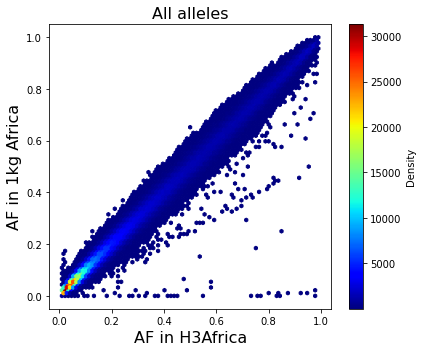

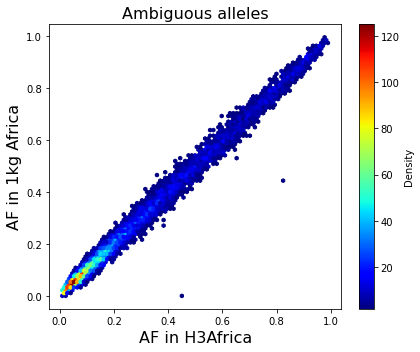

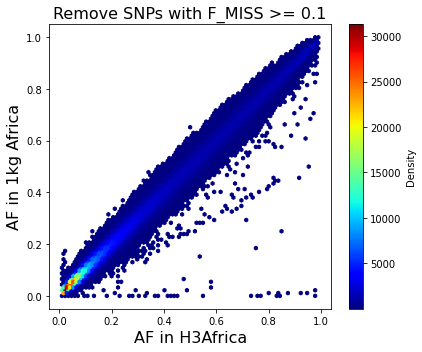

In [47]:
min_num = 2

fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final.AF_h3_AFR.tolist()
y = merged_filter_final.AF_1kg_AFR.tolist()
plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa", fontsize=16)
plt.title("All alleles", fontsize=16)
plt.tight_layout()
plt.show()

# compare only ambiguous_alleles allele frequencies
fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final[ambiguous_alleles].AF_h3_AFR.tolist()
y = merged_filter_final[ambiguous_alleles].AF_1kg_AFR.tolist()
plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa",fontsize=16)
plt.title("Ambiguous alleles",fontsize=16)
plt.tight_layout()
plt.show()

# compare only ambiguous_alleles allele frequencies
fig, ax = plt.subplots(figsize=(6,5))
x = merged_filter_final[merged_filter_final.F_MISS<0.1].AF_h3_AFR.tolist()
y = merged_filter_final[merged_filter_final.F_MISS<0.1].AF_1kg_AFR.tolist()
plt.hexbin(x, y, gridsize=80, cmap="jet", mincnt=min_num)
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel("AF in H3Africa", fontsize=16)
plt.ylabel("AF in 1kg Africa",fontsize=16)
plt.title("Remove SNPs with F_MISS >= 0.1",fontsize=16)
plt.tight_layout()
plt.show()

